In [2]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
from scipy.io.wavfile import write
from IPython.display import Audio

In [113]:
# Define file paths
input_video_path = '/kaggle/input/more-instruments/trombone.mp4'
extracted_audio_path = '/kaggle/working/trombone_sound.wav'
input_audio_path = '/kaggle/input/aiekfhsdkfjg/1047_c/sample_1a/sample.wav'
synthesized_audio_path = '/kaggle/working/sample.wav'

In [114]:
# # Command to extract audio using FFmpeg
# command = f'ffmpeg -i {input_video_path} -ab 160k -ac 2 -ar 44100 -vn {extracted_audio_path}'

# # Execute the command
# subprocess.call(command, shell=True)

In [121]:
#--- Extact Audio from Video File---#

def extract_audio(input_video_path, extracted_audio_path):

    # Command to extract audio using FFmpeg
    command = f'ffmpeg -i {input_video_path} -ab 160k -ac 2 -ar 44100 -vn {extracted_audio_path}'

    # Execute the command
    subprocess.call(command, shell=True)
    
    pass

#--- Load Audio File ---#

def load_audio(input_audio_path):

    sample_rate, data = wavfile.read(input_audio_path)
    
    duration = len(data) / sample_rate
    
    # If audio is stereo, use only one channel
    if len(data.shape) > 1:
        data = data[:, 0]
        
    # Normalize data
    data = data / np.max(np.abs(data), axis=0)
    
    return data, sample_rate, duration

#--- Applying FFT ---#
def apply_fft(data, sample_rate):
    
    # Apply FFT to data
    fft_values = fft(data)
    frequencies = fftfreq(len(data), 1 / sample_rate)
    
    # Keep only Positive Frequencies and FFT Values
    positive_frequencies = frequencies[:len(frequencies) // 2]
    positive_fft_values = fft_values[:len(fft_values) // 2]
    
    return positive_frequencies, positive_fft_values

#--- Peak Detection ---#
def detect_peaks(positive_frequencies, positive_fft_values):
    # Perform peak detection
    peaks, properties = find_peaks(np.abs(positive_fft_values), 
                                   height=0, 
                                   distance=sample_rate/50, 
                                   prominence=10)
    # Peaks must stand out from surrounding data by a height of 800 to be considered significant.

    # Filter peaks to include only those within a certain frequency range
    max_frequency = 18000  # Set maximum frequency range to 5000 Hz for violin harmonics
    filtered_peaks = peaks[positive_frequencies[peaks] < max_frequency]
    filtered_peak_freqs = positive_frequencies[filtered_peaks]
    filtered_peak_amps = np.abs(positive_fft_values)[filtered_peaks]
    return filtered_peak_freqs, filtered_peak_amps, max_frequency

#--- Plot Frequency Spectrum ---#
def plot_freq_spectrum(positive_frequencies, positive_fft_values, filtered_peak_freqs, filtered_peak_amps, max_frequency):
    
    # Visualize the frequency spectrum and save as an image file.
    plt.figure(figsize=(14, 5))
    plt.plot(positive_frequencies, np.abs(positive_fft_values), label='Magnitude')
    plt.scatter(filtered_peak_freqs, filtered_peak_amps, color='red', label='Peaks')
    plt.title('Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.legend()
    plt.xlim(0, max_frequency)
    plt.savefig(f"/kaggle/working/feq_spec.png")
    plt.show()

    # Save the lists of frequencies and amplitudes to a text file.
    data_filename = f"/kaggle/working/feq_data.txt"
    with open(data_filename, 'w') as file:
        file.write("Peak Frequencies:\n")
        file.write(', '.join(map(str, filtered_peak_freqs)) + '\n\n')
        file.write("Peak Amplitudes:\n")
        file.write(', '.join(map(str, filtered_peak_amps)) + '\n\n')
    
    # Return the number of peaks after filtering by frequency range.
    print(f"Number of peaks: {len(filtered_peak_freqs)}")
    print(filtered_peak_freqs)
    print(filtered_peak_amps)

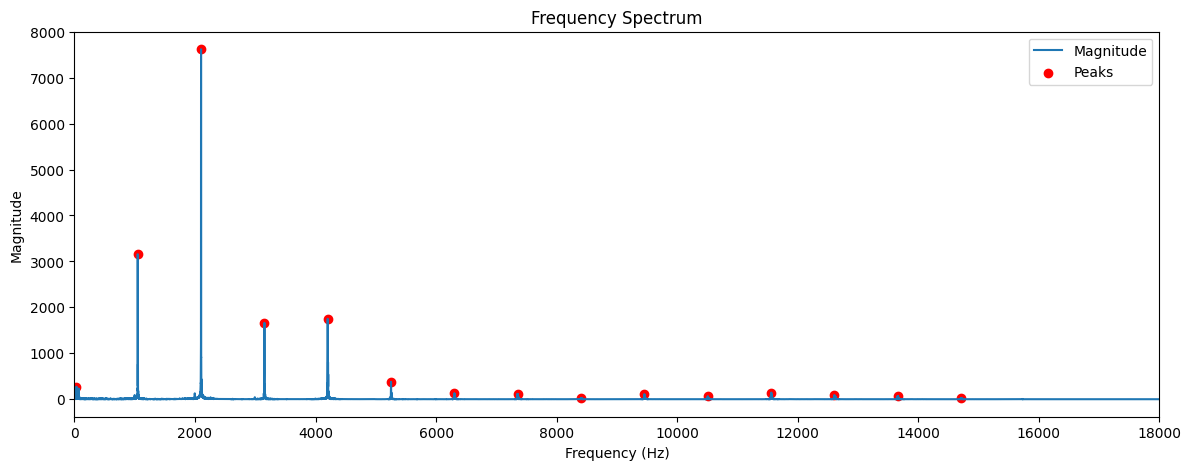

Number of peaks: 15
[   34.33212809  1050.56311956  2101.12623912  3152.45229486
  4202.25247825  5252.81559781  6301.85284501  7352.41596457
  8410.60844593  9455.83101223 10509.44587651 11562.29780461
 12608.28330709 13664.18697991 14708.64661004]
[ 272.81948837 3157.17614624 7619.79096211 1662.83339536 1749.87046783
  378.63599275  126.84416526  117.81416742   26.54097964  111.41759938
   61.47580085  144.70319279   90.51120124   69.60591411   24.87346005]


In [122]:
# extract_audio(input_video_path, extracted_audio_path)
data, sample_rate, duration = load_audio(input_audio_path)
positive_frequencies, positive_fft_values = apply_fft(data, sample_rate)
filtered_peak_freqs, filtered_peak_amps, max_frequency = detect_peaks(positive_frequencies, positive_fft_values)
plot_freq_spectrum(positive_frequencies, positive_fft_values, filtered_peak_freqs, filtered_peak_amps, max_frequency)

In [12]:
def synthesize_sound(sample_rate, filtered_peak_freqs, filtered_peak_amps):
    output_duration = 5                                 # Duration of output sound in seconds.
    output_data_length = output_duration * sample_rate  # Length of output sound data.

    output_sound = np.zeros(output_data_length)

    output_time = np.arange(output_data_length) / sample_rate # Array of time values.

    for freq, amp in zip(filtered_peak_freqs, filtered_peak_amps):
        output_sound += amp * np.sin(2 * np.pi * freq * output_time)
        
    return output_sound, output_time, output_duration

def sigmoid(x, L=1, k=1, x0=0):
    """Sigmoid function for the attack and release phases."""
    return L / (1 + np.exp(-k * (x - x0)))

def adsr_envelope(t,  duration, attack=0.1, release=0.1):
    if t < attack:
        return sigmoid(t, L=1, k=10/attack, x0=attack/2)
    elif t < duration - release:
        return 1
    elif t < duration:
        return 1 - sigmoid(t - (duration - release), L=1, k=10/release, x0=release/2)
    else:
        return 0

def apply_envelope(output_sound, output_time, output_duration):
    # Apply the ADSR envelope to the synthesized sound
    envelope = np.array([adsr_envelope(ti, output_duration) for ti in output_time])
    output_sound *= envelope
    return output_sound

def normalize_sound(output_sound):
    output_sound /= np.max(np.abs(output_sound))
    return output_sound
    
def save_sound(synthesized_audio_path, output_sound, sample_rate):
    write(synthesized_audio_path, sample_rate, output_sound.astype(np.float32))

L: The maximum value of the sigmoid, set to 1 to reach the full amplitude.

k: Controls the steepness of the curve. A higher k makes the transition faster. It's adjusted based on the attack duration to ensure the curve fits within the attack phase.

x0: The midpoint of the sigmoid, set to half of the attack duration.

In [7]:
output_sound, output_time, output_duration = synthesize_sound(sample_rate, filtered_peak_freqs, filtered_peak_amps)
output_sound = apply_envelope(output_sound, output_time, output_duration)
output_sound = normalize_sound(output_sound)
Audio(output_sound, rate=sample_rate)